In [86]:
import flopy as fp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [59]:
mpexe = "../../../../exe/mp7.exe"
mfexe = "../../../../exe/mf6.exe"
m_name = "mp_sim"
ws = "workspace"

In [60]:
#dis
nlay = 3
nrow = 30
ncol = 30
Lx = 100
Ly = 100
delc = Ly/nrow
delr = Lx/ncol
botm = [5,4,0]
top = 10

In [168]:
#parameters

kh = np.array([1e-3,1e-5,1e-4])
kv = kh/3

In [169]:
#tdis
nper = 1
pd = (1,1.,1.)

In [179]:
## BC
riv1_spd = [((0,ir,0),10) for ir in range(nrow)]
riv2_spd = [((0,ir,ncol-1),7) for ir in range(nrow)]

wel_spd = [((2,15,15),-0.0055)]

In [180]:
#packages
sim = fp.mf6.MFSimulation(sim_name=m_name, exe_name=mfexe,version='mf6', sim_ws=ws)
tdis = fp.mf6.modflow.mftdis.ModflowTdis(sim, pname='tdis',time_units='DAYS', nper=nper,perioddata=[pd])
gwf = fp.mf6.ModflowGwf(sim, modelname=m_name,model_nam_file=m_name+".nam", save_flows=True)
ims = fp.mf6.modflow.mfims.ModflowIms(sim,complexity="SIMPLE")
dis = fp.mf6.ModflowGwfdis(gwf,pname='dis', nlay=nlay,nrow=nrow, ncol=ncol,length_units='METERS',
                           delr=delr, delc=delc,top=top,botm=botm)
ic = fp.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname='ic', strt=top)
npf = fp.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, pname='npf',icelltype=[1,0,0], k=kh,k33=kv)
rch = fp.mf6.ModflowGwfrcha(gwf,recharge=700/1000/365/86400,save_flows=True)
wel = fp.mf6.ModflowGwfwel(gwf,pname="puits",maxbound=1,stress_period_data=wel_spd,save_flows=True)
riv1 = fp.mf6.ModflowGwfchd(gwf,pname="riv1",filename="riv1.chd",maxbound=len(riv1_spd),stress_period_data=riv1_spd)
riv2 = fp.mf6.ModflowGwfchd(gwf,pname="riv2",filename="riv2.chd",maxbound=len(riv2_spd),stress_period_data=riv2_spd)

# Create the output control package
oc = fp.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, pname='oc',
                                            saverecord=[('HEAD', 'ALL'),('BUDGET', 'ALL')],
                                            head_filerecord='{}.hds'.format(m_name),
                                            budget_filerecord='{}.cbc'.format(m_name))

In [181]:
sim.write_simulation(silent=True)
sim.run_simulation(silent=True)

(True, [])

Bien ! Maintenant que nous avons un modèle modflow, essayons un exemple de forward tracking (on lâche des particules à des endroits et on regarde où elles arrivent)

Pour cela on utilise modpath et on va lui spécifier deux choses : 
- le sens que l'on souhaite observer (forward ou backward)
- où mettre des particules

La position des particules peut se faire facilement en en mettant partout (avec un certain espacement en x, y et z --> rowcelldivisions, columncelldivisions et layercelldivisions). Il est aussi possible de spécifier noeuds par noeuds avec la variable *nodes*. **Les noeuds doivent absolument être sous la forme d'un seul nombre (nrow x ncol x ilay + ncol x ir + ic)**

In [182]:
mpnamf = m_name + '_mp_forward'

# create basic forward tracking modpath simulation
mp = fp.modpath.Modpath7.create_mp7(modelname=mpnamf, trackdir='forward', flowmodel=gwf, model_ws=ws, 
                                       rowcelldivisions=1, columncelldivisions=1, layercelldivisions=1,
                                       exe_name=mpexe)
mp.write_input()
mp.run_model()

FloPy is using the following  executable to run the model: ../../../../exe/mp7.exe

MODPATH Version 7.2.001   
Program compiled Mar 21 2019 15:41:25 with IFORT compiler (ver. 19.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      2700 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

Regardons les résultats

In [190]:
wel_id = wel.stress_period_data.get_data()[0]["cellid"][0]
node =wel_id[0]*nrow*ncol + wel_id[1]*ncol + wel_id[2]

fpth = os.path.join(ws, mpnamf + '.mppth')
p = fp.utils.PathlineFile(fpth)
pline = p.get_destination_pathline_data(dest_cells=node)

In [191]:
fpth = os.path.join(ws, mpnamf + '.mpend')
endp = fp.utils.EndpointFile(fpth)
wel_endp = endp.get_destination_endpoint_data(dest_cells=node)

In [203]:
wel_endp["node0"][wel_endp["time"]<10000]

array([1365, 2235, 2264, 2265, 2266, 2295])

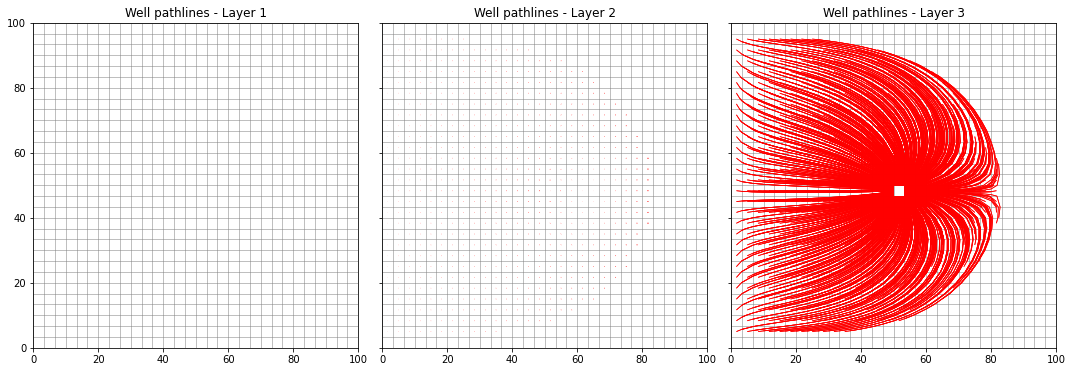

In [196]:
f, axes = plt.subplots(ncols=3, nrows=1, sharey=True, figsize=(15, 5))
axes = axes.flatten()

ix = 0
for k in range(nlay):
    ax = axes[ix]
    ax.set_aspect('equal')
    ax.set_title('Well pathlines - Layer {}'.format(k+1))
    mm = fp.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(lw=0.5)
    mm.plot_pathline(pw, layer=k, colors="red", lw=0.75)
    ix += 1
    
plt.tight_layout();

In [185]:
h_path = "workspace/mp_sim.hds"
head = fp.utils.HeadFile(h_path).get_data()

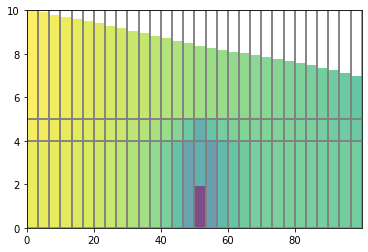

In [225]:
x = fp.plot.PlotCrossSection(gwf,line={"row":15})
x.plot_array(head,head=head,alpha=0.7)
x.plot_grid()

In [228]:
pline

[rec.array([( 1.6666667, 65.      , 7.5      , 0.0000000e+00, 0, 300),
            ( 1.6666671, 65.      , 7.5      , 9.9999998e-03, 0, 300),
            ( 1.6666676, 65.      , 7.5      , 2.0000000e-02, 0, 300),
            ( 1.666668 , 65.      , 7.5      , 2.9999999e-02, 0, 300),
            ( 1.6666687, 65.      , 7.5      , 3.9999999e-02, 0, 300),
            ( 1.666669 , 65.      , 7.5      , 5.0000001e-02, 0, 300),
            ( 1.6666695, 65.      , 7.5      , 5.9999999e-02, 0, 300),
            ( 1.66667  , 65.      , 7.5      , 7.0000000e-02, 0, 300),
            ( 1.6666704, 65.      , 7.5      , 7.9999998e-02, 0, 300),
            ( 1.6666709, 65.      , 7.5      , 9.0000004e-02, 0, 300),
            ( 1.6666714, 65.      , 7.5      , 1.0000000e-01, 0, 300),
            ( 1.6666719, 65.      , 7.5      , 1.1000000e-01, 0, 300),
            ( 1.6666723, 65.      , 7.5      , 1.2000000e-01, 0, 300),
            ( 1.6666728, 65.      , 7.5      , 1.3000000e-01, 0, 300),
      